In [1]:
# in the name of god 

In [2]:
import pandas as pd 
import numpy as np
from IPython.display import clear_output
import time
import pickle

import matplotlib.pyplot as plt
from matplotlib.cbook import flatten
import matplotlib.cm as cm
import matplotlib as matplotlib

def color_map_color(value, cmap_name='coolwarm', vmin=0, vmax=10):
    # norm = plt.Normalize(vmin, vmax)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)  # PiYG
    rgb = cmap(norm(abs(value)))[:3]  # will return rgba, we take only first 3 so we get rgb
    color = matplotlib.colors.rgb2hex(rgb)
    return color

# Display figures inline in Jupyter notebook
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 5)})

In [3]:
#prepare Dataset gyroscope
dfg=pd.read_csv('21\giroscopio_terra.csv')
dfg['ts']=pd.to_datetime(dfg.apply(lambda x:(round((x.uptimeNanos-dfg.uptimeNanos[0])/1000000)*1000000),axis=1))
dm=dfg['ts']
dfg=dfg.drop('uptimeNanos',1).drop('timestamp',1)
dfg=dfg.set_index('ts').rename(columns={'x': 'g-x','y': 'g-y','z': 'g-z'})
dfg.head(3)

,g-x,g-y,g-z
ts,,,
1970-01-01 00:00:00.000,0.031439,0.360042,0.009180
1970-01-01 00:00:00.015,0.235446,0.680577,-0.039432
1970-01-01 00:00:00.035,0.118159,0.084886,-0.087033


In [4]:
#prepare Dataset accelarator
dfa=pd.read_csv('21\\acelerometro_terra.csv')
dfa['ts']=dm
dfa=dfa.drop('uptimeNanos',1).drop('timestamp',1)
dfa=dfa.set_index('ts').rename(columns={'x': 'a-x','y': 'a-y','z': 'a-z'})
dfa.head(3)

,a-x,a-y,a-z
ts,,,
1970-01-01 00:00:00.000,0.336558,-0.169031,9.658637
1970-01-01 00:00:00.015,2.022178,-0.125877,9.948004
1970-01-01 00:00:00.035,0.777634,-0.088642,11.809340


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001BF4406ADC8>,
      dtype=object)

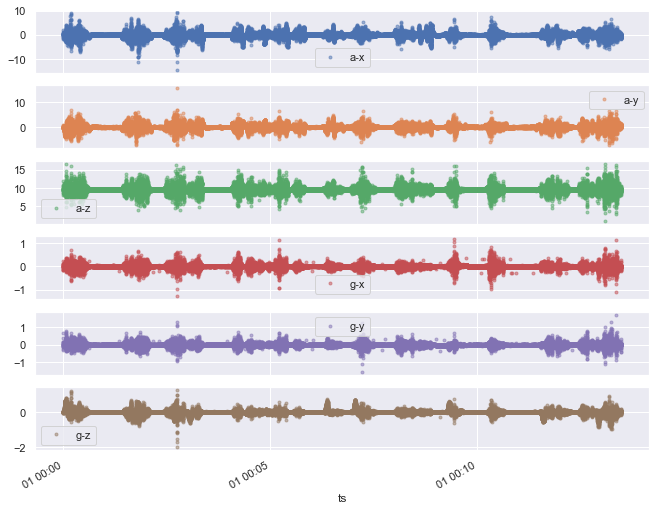

In [5]:
df = pd.concat([dfa, dfg], axis=1, join='outer')
df.plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)

In [6]:
#prepare Labeled dataset
dfl=pd.read_csv('21\\groundTruth.csv')
dfl['length']=dfl.en-dfl.st
lmean=dfl.length.mean()
lstd=dfl.length.std()

#extract the labels for clutering precision its for after clustering
def time_convertor(x):
    s,h,m=0,0,0
    s=round(x%60,2)
    m=int(x/60)
    h=int(m/60)
    m=m%60
    time=str(h)+':'+str(m)+':'+str(s)
    return pd.to_datetime('1970-01-01 '+time)

dfl['st_time']=dfl.apply(lambda x:time_convertor(x.st) ,axis=1 )
dfl['en_time']=dfl.apply(lambda x:time_convertor(x.en) ,axis=1 )
dfl=dfl.drop('st',1).drop('en',1).drop('length',1)
evented_label=list()
for i in range(len(dfl)):
    evented_label.append((dfl.iloc[i][0],dfl.iloc[i][1],dfl.iloc[i][2]))

In [7]:
#Dont RUN this part
#we should optimize M
#lengh of random event
from random import gauss
L=round(gauss(lmean,lstd)*50)
M=round(gauss(0.5,0.5)*50)

temp_event=list()
pointer=0
stop=False
#go on timeserise for event extraction
while stop!=True:
    clear_output(wait=True)
    M=round(gauss(0.5,0.5)*50)
    pointer=pointer + M
    #go forward till reach M
    L=round(gauss(lmean,lstd)*50)
    l_min=pointer-int(L/2)
    l_max=pointer+int(L/2)
    if (l_min<0):
        l_min=0
    if (l_max>len(df)):
        l_max=len(df)
        stop=True

    print('extraction ',l_max/len(df),' %  is complete')
    
    temp_event.append(df[l_min:l_max])


extraction  1.0  %  is complete


In [8]:
#Dont RUN this part
#calculate distance
from fastdtw import fastdtw
distance=list()
n=0
k=(len(temp_event))
k=k*k
t1=time.time()
for i,x in enumerate(temp_event):
    dumy=list()
    for j,y in enumerate(temp_event):
        clear_output(wait=True)
        n=n+1
        print('disstance calculatoin ',round((n/k)*100,4),' %  is complete')
        if (i<=j):
            continue
        else:
            dist,_=fastdtw(x,y)
            dumy.append(dist)
        
    distance.append(dumy)
t2=time.time()
print(round((t2-t1)/60) ,'min has time for calculaton distant')


disstance calculatoin  100.0  %  is complete
1658 min has time for calculaton distant


In [9]:
#Dont RUN this part
#clustering precision
n=0
k=len(temp_event)*len(evented_label)
labels_distance=list()

for tag,st,en in evented_label:
    dummy=list()
    for t_e in temp_event:
        clear_output(wait=True)
        n=n+1
        print('disstance calculatoin ',round((n/k)*100,2),' %  is complete')
        dist,_=fastdtw(df[st:en],t_e)
        dummy.append(dist)
    labels_distance.append((tag,dummy))


disstance calculatoin  100.0  %  is complete


In [10]:
#Save temp_event
with open("temp_event_on21.txt", "wb") as fp:
    pickle.dump(temp_event, fp)

#Save distance matrix
with open("distance_on21.txt", "wb") as fp:
    pickle.dump(distance, fp)
    
#Save labeds distance matrix
with open("labels_distance_on21.txt", "wb") as fp:
    pickle.dump(labels_distance, fp)    

In [7]:
#load File , save the time of calculation
with open("temp_event_on21.txt", "rb") as fp:
    te = pickle.load(fp)
with open("distance_on21.txt", "rb") as fp:
    dc = pickle.load(fp)
with open("labels_distance_on21.txt", "rb") as fp:
    ld = pickle.load(fp)

In [8]:
#make it as matrix 
#full it with zero for squaring
from copy import deepcopy
def creat_Symmetric_matrix(file):  
    MTX=deepcopy(file)
    for i in range(len(MTX)):
        while len(MTX[i])!=len(MTX):
            MTX[i].append(0)
    #make it Symmetry from diameter
    arr=np.array(MTX)
    dis=np.array(MTX)
    for i in range(len(arr)):
        for j in range(len(arr)):
            if (i>j):
                dis[j][i]=arr[i][j]
    return dis
dis=creat_Symmetric_matrix(dc)

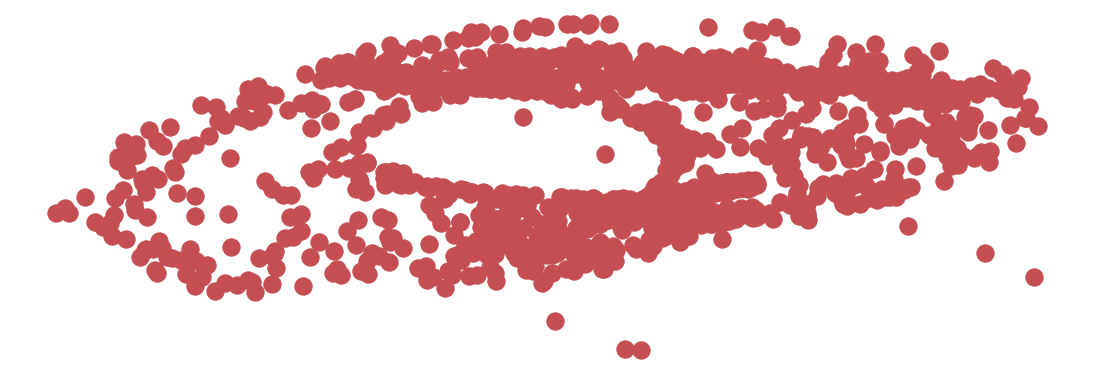

In [8]:
#PLOT GRAPH
import networkx as nx
G = G=nx.from_numpy_matrix(dis)
nx.draw(G,edge_color ='w', edge_cmap=plt.cm.winter ,node_color='r')

No handles with labels found to put in legend.


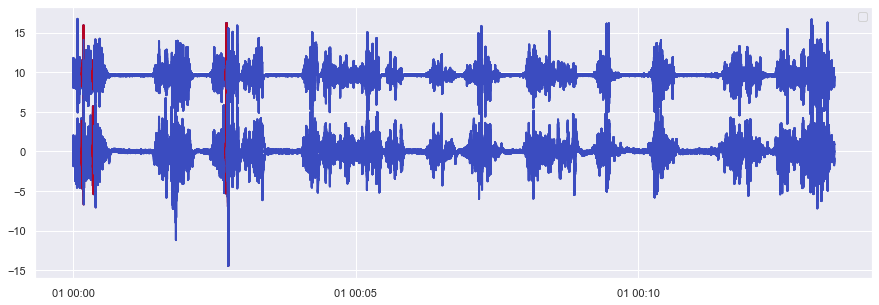

In [9]:
#initial clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

cluster = AgglomerativeClustering(n_clusters=4, affinity='precomputed', linkage = 'average').fit(dis)

plot_list=list()
for i,el in enumerate(te):
    plot_list.append((el,cluster.labels_[i]))
    
fig, ax = plt.subplots()

for el in plot_list:
    ax.plot(el[0], linestyle='-', linewidth=2,c=color_map_color(el[1]*10))
ax.legend();
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


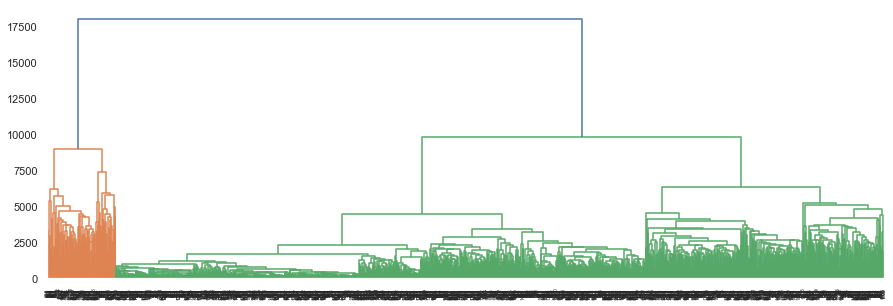

In [10]:
Z = hierarchy.linkage(dis, 'average')
plt.figure()
dn = hierarchy.dendrogram(Z)

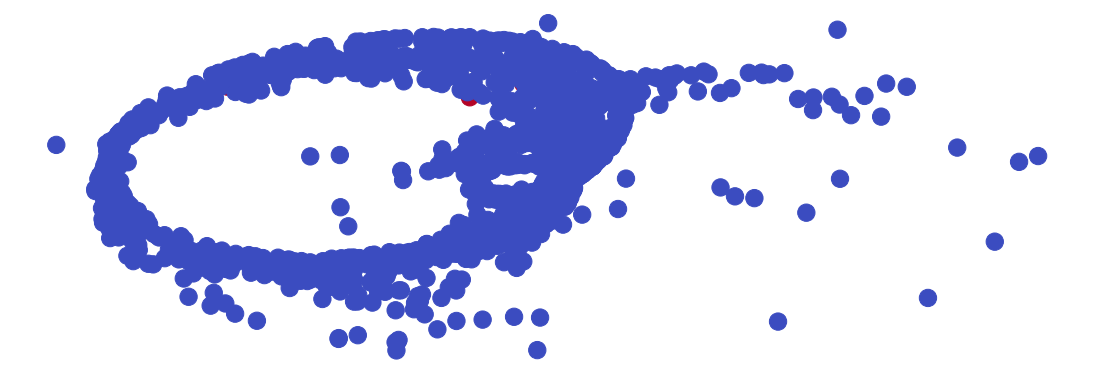

In [11]:
color_map = []
for cl in cluster.labels_:
    color_map.append(color_map_color(cl*10))

nx.draw(G,edge_color ='w', node_color=color_map)
plt.show()

In [12]:
#calculate the precision of clustering by labeled data 
exploratory_analysis=list()
for el in ld:
    midle_list=list()
    label_tag =el[0]
    label_distance=el[1].copy()
    label_distance.append(0)
    distance_matrix=dc.copy()
    distance_matrix.append(label_distance)
    DMX=creat_Symmetric_matrix(distance_matrix)
    Labels = AgglomerativeClustering(n_clusters=22, affinity='precomputed', linkage = 'average').fit(DMX).labels_

    #extract lable  and labele it from the item we put at the end
    for i , x in enumerate(Labels):
        if i!=(len(Labels)-1):
            if x==Labels[-1]:
                midle_list.append(i)
    exploratory_analysis.append([label_tag,midle_list])
actg=dict()
for ev,x in exploratory_analysis:
    if ev in actg:
        actg[ev].append(x)
    else:
        actg.update({ev:[x]})

In [13]:
#calculate the Probibility of being event of temp_event
Prob_threshold=0.2
precision=list()

for event_name in actg:
    flat_list=list(dict.fromkeys(flatten(actg[event_name])))
    dprecision=list()
    for S in flat_list:
        x=0
        Number=len(actg[event_name])
        for i in range(Number):
            if S in actg[event_name][i]:
                x=x+1
        Probability=x/Number
        if Probability > Prob_threshold:
            dprecision.append((S,Probability))
    precision.append((event_name,dprecision))

as you can see its the Selected event and their Probability

In [14]:
precision[1]

('troca_faixa_esquerda_agressiva',
 [(0, 0.5),
  (1, 0.5),
  (2, 0.5),
  (3, 0.5),
  (4, 0.5),
  (5, 0.5),
  (8, 0.5),
  (9, 0.5),
  (10, 0.5),
  (11, 0.5),
  (12, 0.5),
  (13, 0.5),
  (14, 0.5),
  (15, 0.5),
  (16, 0.5),
  (19, 0.5),
  (20, 0.5),
  (21, 0.5),
  (22, 0.5),
  (23, 0.5),
  (24, 0.5),
  (25, 0.5),
  (26, 0.5),
  (27, 0.5),
  (28, 0.5),
  (29, 0.5),
  (30, 0.5),
  (31, 0.5),
  (32, 0.5),
  (33, 0.5),
  (34, 0.5),
  (35, 0.5),
  (36, 0.5),
  (37, 0.5),
  (38, 0.5),
  (39, 0.5),
  (40, 0.5),
  (41, 0.5),
  (42, 0.5),
  (43, 0.5),
  (45, 0.5),
  (46, 0.5),
  (47, 0.5),
  (48, 0.5),
  (49, 0.5),
  (50, 0.5),
  (51, 0.5),
  (52, 0.5),
  (53, 0.5),
  (54, 0.5),
  (55, 0.5),
  (56, 0.5),
  (57, 0.5),
  (58, 0.5),
  (59, 0.5),
  (60, 0.5),
  (61, 0.5),
  (62, 0.5),
  (63, 0.5),
  (64, 0.5),
  (65, 0.5),
  (66, 0.5),
  (67, 0.5),
  (68, 0.5),
  (69, 0.5),
  (70, 0.5),
  (71, 0.5),
  (72, 0.5),
  (73, 0.5),
  (74, 0.5),
  (75, 0.5),
  (76, 0.5),
  (77, 0.5),
  (78, 0.5),
  (79, 0.5)

as you can see its the Selected event and their Probability

In [15]:
precision[2]

('freada_agressiva',
 [(413, 0.6666666666666666),
  (414, 0.6666666666666666),
  (415, 0.6666666666666666),
  (540, 0.6666666666666666),
  (541, 0.6666666666666666),
  (606, 0.6666666666666666),
  (607, 0.6666666666666666),
  (689, 0.6666666666666666),
  (690, 0.6666666666666666)])

but in the others event we have nothing to say because its too much data and it seems somethings goes wrong

maybe if we increase Data , and done this algorithm again could be conclude something

In [16]:
precision[3]

('aceleracao_agressiva',
 [(0, 0.8333333333333334),
  (1, 0.8333333333333334),
  (2, 0.8333333333333334),
  (3, 0.8333333333333334),
  (4, 0.8333333333333334),
  (5, 0.8333333333333334),
  (8, 0.8333333333333334),
  (9, 0.8333333333333334),
  (10, 0.8333333333333334),
  (11, 0.8333333333333334),
  (12, 0.8333333333333334),
  (13, 0.8333333333333334),
  (14, 0.8333333333333334),
  (15, 0.8333333333333334),
  (16, 0.8333333333333334),
  (19, 0.8333333333333334),
  (20, 0.8333333333333334),
  (21, 0.8333333333333334),
  (22, 0.8333333333333334),
  (23, 0.8333333333333334),
  (24, 0.8333333333333334),
  (25, 0.8333333333333334),
  (26, 0.8333333333333334),
  (27, 0.8333333333333334),
  (28, 0.8333333333333334),
  (29, 0.8333333333333334),
  (30, 0.8333333333333334),
  (31, 0.8333333333333334),
  (32, 0.8333333333333334),
  (33, 0.8333333333333334),
  (34, 0.8333333333333334),
  (35, 0.8333333333333334),
  (36, 0.8333333333333334),
  (37, 0.8333333333333334),
  (38, 0.8333333333333334),
  (

In [10]:
#plot and optimize the number of the cluster and the linkage method
def Mean(dprecision):
    return np.mean(list(dict(dprecision).values()))

def Oploter(number_of_cluster , linkage_method):
    #calculate the precision of clustering by labeled data 
    exploratory_analysis=list()
    for el in ld:
        midle_list=list()
        label_tag =el[0]
        label_distance=el[1].copy()
        label_distance.append(0)
        distance_matrix=dc.copy()
        distance_matrix.append(label_distance)
        DMX=creat_Symmetric_matrix(distance_matrix)
        Labels = AgglomerativeClustering(n_clusters=number_of_cluster, affinity='precomputed', linkage = linkage_method).fit(DMX).labels_

        #extract lable  and labele it from the item we put at the end
        for i , x in enumerate(Labels):
            if i!=(len(Labels)-1):
                if x==Labels[-1]:
                    midle_list.append(i)
        exploratory_analysis.append([label_tag,midle_list])
    actg=dict()
    for ev,x in exploratory_analysis:
        if ev in actg:
            actg[ev].append(x)
        else:
            actg.update({ev:[x]})
    #calculate the Probibility of being event of temp_event
    Prob_threshold=0.1
    precision=list()
    for event_name in actg:
        flat_list=list(dict.fromkeys(flatten(actg[event_name])))
        dprecision=list()
        for S in flat_list:
            x=0
            Number=len(actg[event_name])
            for i in range(Number):
                if S in actg[event_name][i]:
                    x=x+1
            Probability=x/Number
            if Probability > Prob_threshold:
                dprecision.append((S,Probability))
        precision.append((event_name,len(dprecision),Mean(dprecision),dprecision))
    return precision


In [23]:
#linkage method average
linkage_mth='average'
Ya=list()
t1=time.time()
for num_cl in range(1,500,10):
    X=Oploter(num_cl,linkage_mth)
    Ya.append(X)
t2=time.time()
print(round((t2-t1)/60) ,'min has time for calculaton distant')

88 min has time for calculaton distant


No handles with labels found to put in legend.


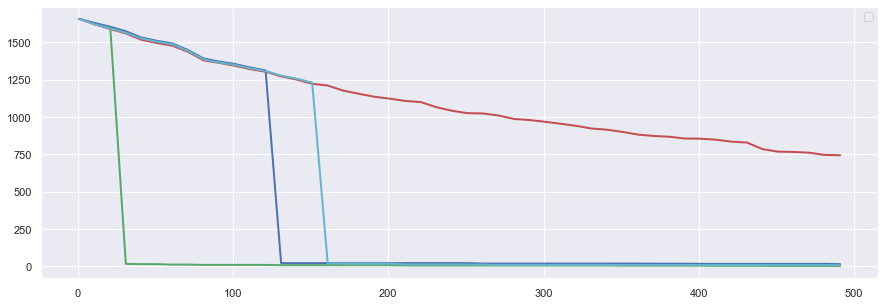

In [21]:
Ya_N1=[x[0][1] for x in Ya]
Ya_N2=[x[1][1] for x in Ya]
Ya_N3=[x[2][1] for x in Ya]
Ya_N4=[x[3][1] for x in Ya]
X = range(1,500,10)
fig, ax = plt.subplots()

ax.plot(X,Ya_N1, linestyle='-', linewidth=2,c='r')
ax.plot(X,Ya_N2, linestyle='-', linewidth=2,c='g')
ax.plot(X,Ya_N3, linestyle='-', linewidth=2,c='b')
ax.plot(X,Ya_N4, linestyle='-', linewidth=2,c='c')

ax.legend();
plt.show() 

No handles with labels found to put in legend.


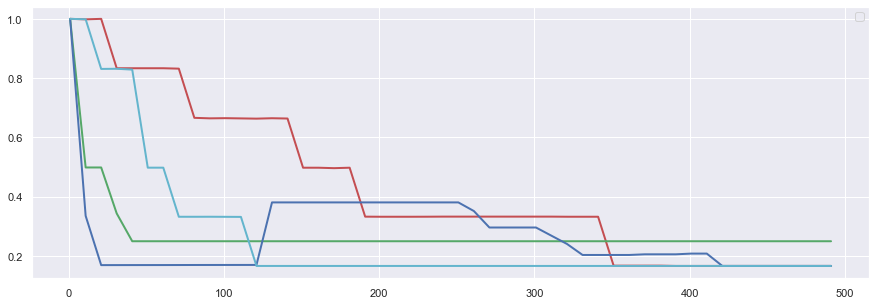

In [23]:
Ya_Q1=[x[0][2] for x in Ya]
Ya_Q2=[x[1][2] for x in Ya]
Ya_Q3=[x[2][2] for x in Ya]
Ya_Q4=[x[3][2] for x in Ya]

X = range(1,500,10)

fig, ax = plt.subplots()

ax.plot(X,Ya_Q1, linestyle='-', linewidth=2,c='r')
ax.plot(X,Ya_Q2, linestyle='-', linewidth=2,c='g')
ax.plot(X,Ya_Q3, linestyle='-', linewidth=2,c='b')
ax.plot(X,Ya_Q4, linestyle='-', linewidth=2,c='c')
ax.legend();
plt.show() 

In [46]:
#linkage method average
linkage_mth='average'
Ya=list()
t1=time.time()
for num_cl in range(20,30):
    X=Oploter(num_cl,linkage_mth)
    Ya.append(X)
t2=time.time()
print(round((t2-t1)/60) ,'min has time for calculaton distant')

27 min has time for calculaton distant


No handles with labels found to put in legend.


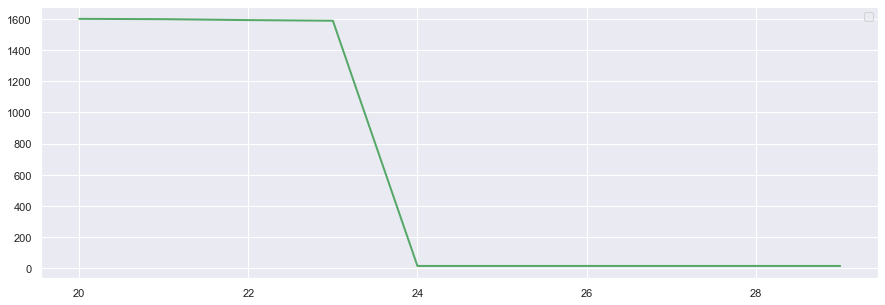

In [20]:
Ya_N2=[x[1][1] for x in Ya]
X = range(20,30)
fig, ax = plt.subplots()

ax.plot(X,Ya_N2, linestyle='-', linewidth=2,c='g')

ax.legend();
plt.show() 

No handles with labels found to put in legend.


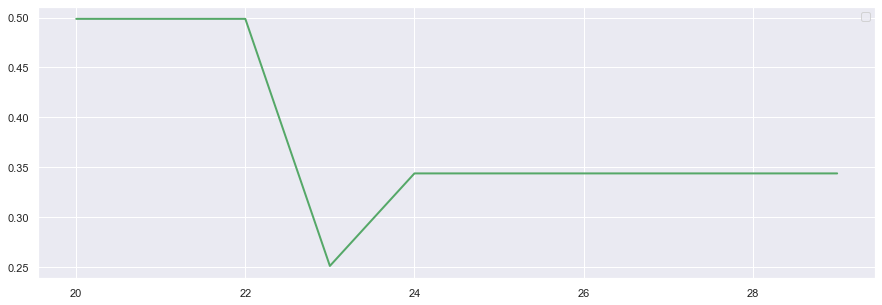

In [21]:
Ya_Q2=[x[1][2] for x in Ya]

X = range(20,30)
fig, ax = plt.subplots()
ax.plot(X,Ya_Q2, linestyle='-', linewidth=2,c='g')
ax.legend();
plt.show() 

In [26]:
#linkage method average
linkage_mth='average'
Yn=list()
t1=time.time()
for num_cl in range(125,160):
    X=Oploter(num_cl,linkage_mth)
    Yn.append(X)
t2=time.time()
print(round((t2-t1)/60) ,'min has time for calculaton distant')

69 min has time for calculaton distant


No handles with labels found to put in legend.


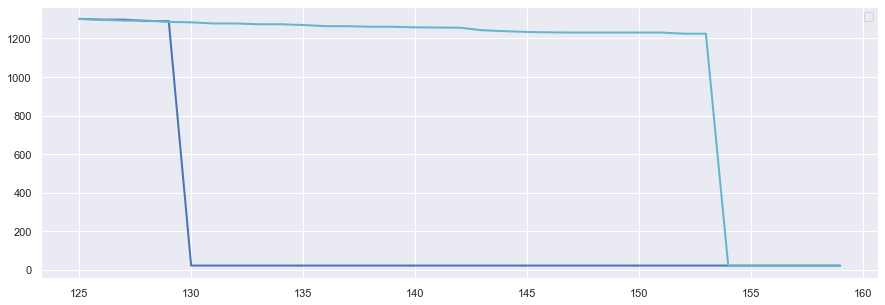

In [31]:
Ya_N3=[x[2][1] for x in Yn]
Ya_N4=[x[3][1] for x in Yn]
X = range(125,160)
fig, ax = plt.subplots()

ax.plot(X,Ya_N3, linestyle='-', linewidth=2,c='b')
ax.plot(X,Ya_N4, linestyle='-', linewidth=2,c='c')

ax.legend();
plt.show() 

No handles with labels found to put in legend.


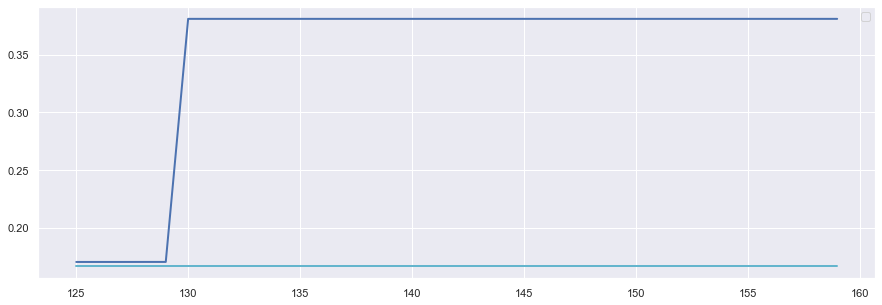

In [33]:
Ya_Q3=[x[2][2] for x in Yn]
Ya_Q4=[x[3][2] for x in Yn]

X = range(125,160)

fig, ax = plt.subplots()

ax.plot(X,Ya_Q3, linestyle='-', linewidth=2,c='b')
ax.plot(X,Ya_Q4, linestyle='-', linewidth=2,c='c')
ax.legend();
plt.show() 

In [39]:
#linkage method average
linkage_mth='average'
Yb=list()
t1=time.time()
for num_cl in range(500,550):
    X=Oploter(num_cl,linkage_mth)
    Yb.append(X)
t2=time.time()
print(round((t2-t1)/60) ,'min has time for calculaton distant')

131 min has time for calculaton distant


No handles with labels found to put in legend.


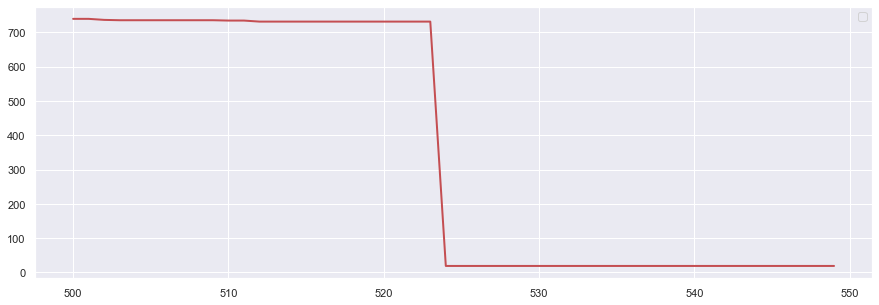

In [40]:
Ya_N1=[x[0][1] for x in Yb]
X = range(500,550)
fig, ax = plt.subplots()

ax.plot(X,Ya_N1, linestyle='-', linewidth=2,c='r')

ax.legend();
plt.show() 

No handles with labels found to put in legend.


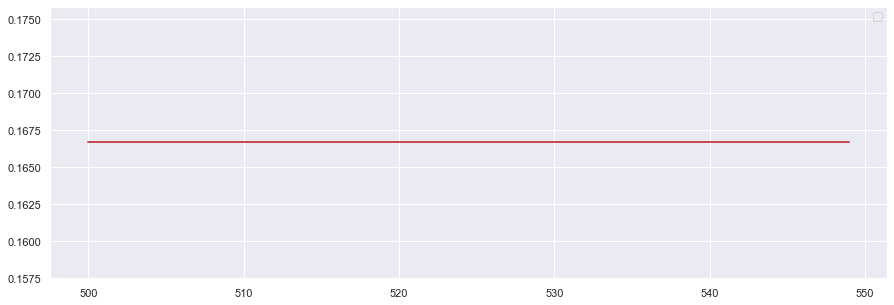

In [42]:
Ya_Q1=[x[0][2] for x in Yb]

X = range(500,550)

fig, ax = plt.subplots()

ax.plot(X,Ya_Q1, linestyle='-', linewidth=2,c='r')
ax.legend();
plt.show() 

In [50]:
OptimizeEvent=list()
OptimizeEvent.append(Ya[24-20][1])#green
OptimizeEvent.append(Yn[130-125][2])#blue
OptimizeEvent.append(Yb[155-125][3])#c
OptimizeEvent.append(Yn[525-500][0])#red
#Save labeds distance matrix
with open("OptimizeLabeldEvent_on21.txt", "wb") as fp:
    pickle.dump(OptimizeEvent, fp)

In [51]:
#load File , save the time of calculation
with open("OptimizeLabeldEvent_on21.txt", "rb") as fp:
    oe = pickle.load(fp)

In [52]:
oe

[('troca_faixa_esquerda_agressiva',
  16,
  0.34375,
  [(45, 0.5),
   (46, 0.5),
   (47, 0.5),
   (191, 0.5),
   (192, 0.5),
   (193, 0.5),
   (16, 0.25),
   (212, 0.25),
   (213, 0.25),
   (214, 0.25),
   (215, 0.25),
   (216, 0.25),
   (344, 0.25),
   (345, 0.25),
   (346, 0.25),
   (347, 0.25)]),
 ('freada_agressiva',
  21,
  0.38095238095238093,
  [(413, 0.6666666666666666),
   (414, 0.6666666666666666),
   (415, 0.6666666666666666),
   (540, 0.6666666666666666),
   (541, 0.6666666666666666),
   (606, 0.6666666666666666),
   (607, 0.6666666666666666),
   (689, 0.6666666666666666),
   (690, 0.6666666666666666),
   (730, 0.16666666666666666),
   (731, 0.16666666666666666),
   (732, 0.16666666666666666),
   (739, 0.16666666666666666),
   (740, 0.16666666666666666),
   (741, 0.16666666666666666),
   (822, 0.16666666666666666),
   (823, 0.16666666666666666),
   (824, 0.16666666666666666),
   (825, 0.16666666666666666),
   (826, 0.16666666666666666),
   (827, 0.16666666666666666)]),
 ('a